http://blog.ezyang.com/2019/05/pytorch-internals/

In [3]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
# Read dataset
path_in = "../data/names.txt"
with open(path_in, 'r') as fh:
    words = fh.read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(chars) + 1

In [6]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # rolling window
    return torch.tensor(X), torch.tensor(Y)

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr,  Ytr  = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])
Xtr.shape, Ytr.shape, Xval.shape, Yval.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [16]:
n_embed = 10
n_hidden = 200
norm = (5/3) / (n_embed * block_size)**0.5  # gain / sqrt(fan_in) for tanh (~0.304)

g = torch.Generator().manual_seed(123)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * norm # multiplier is std in gaussian dist
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
lossi = []
sum(p.nelement() for p in parameters)

12297

In [17]:
max_steps = 200_000
batch_size = 32

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(i, loss.item())
    lossi.append(loss.log10().item())
    # break
    

0 3.2828545570373535
10000 2.3238601684570312
20000 2.1940035820007324
30000 2.2890875339508057
40000 1.9838471412658691
50000 2.109973430633545
60000 2.329263687133789
70000 2.083801031112671
80000 1.8837789297103882
90000 2.0472919940948486
100000 1.9571903944015503
110000 1.9651447534561157
120000 2.2203545570373535
130000 2.0446901321411133
140000 2.0736024379730225
150000 2.087930679321289
160000 2.1019959449768066
170000 1.7698570489883423
180000 2.282078504562378
190000 2.109114408493042


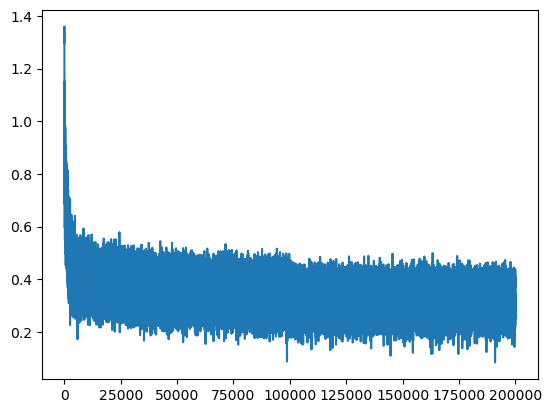

In [7]:
plt.plot(lossi)

In [18]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train'), split_loss('val')

train 2.197749614715576
val 2.268731117248535


(None, None)

```
no weights normalization:
train 2.1127920150756836
val 2.1546456813812256

0.2 norm on W1 
train 2.0390868186950684
val 2.10430908203125

gain/sqrt(dim) norm (~0.304) on W1
train 2.0411272048950195
val 2.105909585952759

batch norm (bad score - maybe too few layers)
train 2.197749614715576
val 2.268731117248535
```

(array([258., 185., 181., 151., 155., 141., 147., 130., 146., 119., 123.,
        114., 120., 130.,  99., 115., 103., 130., 110.,  96., 123., 101.,
        113., 122.,  92., 111., 117.,  97., 106., 106., 115.,  91., 121.,
        111.,  93.,  97., 111., 128., 117., 107., 132., 125., 131., 106.,
        122., 152., 142., 172., 193., 193.]),
 array([-9.99716520e-01, -9.59723521e-01, -9.19730523e-01, -8.79737524e-01,
        -8.39744525e-01, -7.99751526e-01, -7.59758527e-01, -7.19765528e-01,
        -6.79772530e-01, -6.39779531e-01, -5.99786532e-01, -5.59793533e-01,
        -5.19800534e-01, -4.79807535e-01, -4.39814537e-01, -3.99821538e-01,
        -3.59828539e-01, -3.19835540e-01, -2.79842541e-01, -2.39849542e-01,
        -1.99856544e-01, -1.59863545e-01, -1.19870546e-01, -7.98775470e-02,
        -3.98845482e-02,  1.08450651e-04,  4.01014495e-02,  8.00944483e-02,
         1.20087447e-01,  1.60080446e-01,  2.00073445e-01,  2.40066444e-01,
         2.80059443e-01,  3.20052441e-01,  3.60045

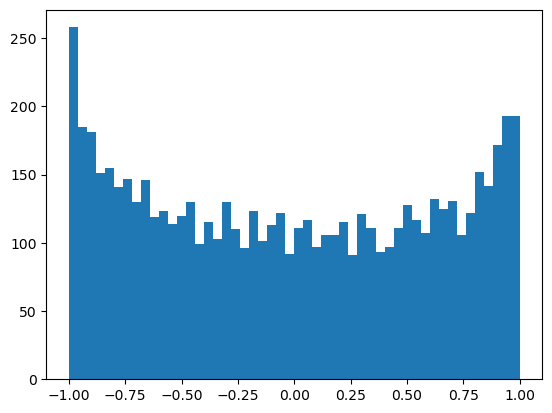

In [47]:
# distribution of h = post-activation
plt.hist(h.view(-1).tolist(), bins=50)

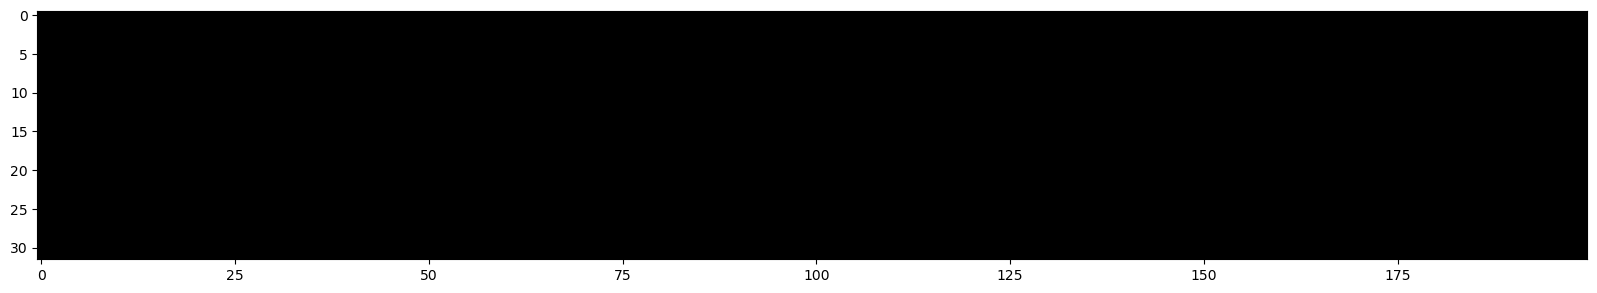

In [44]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### Vanishing gradient
Since the gradients have values close to 1/-1 in most cases, they are going to zero out the gradient in the derivative of tanh. So **the neuron will not learn**. Distribution of h = post-activation:

<img src="imgs/h_plot.png" width=300>

<img src="imgs/tanh.png">

The white gradients will be zero:

<img src="imgs/zero_grad.png">

If an entire column is white, that's a dead neuron = initial values of W are such that all of the learning examples landed in the tail of the activation function, none in the active part

Dead neuron
- always activates by 1/-1 and never learns because the gradient gets zeroed out
- neuron's weights and biases are such that it always outputs values close to zero, regardless of the input
- takes no role in discriminating between inputs


"active part of the tanh"

### Other activation functions and vanishing gradient
- tanh 
- sigmoid <br><img src="imgs/sigmoid_derivative.png" width=150>
- ReLU - d'(x) = 0 if x < 0 else 1 <br>
If at least one input 𝑥∗ has our ReLU on the steep side, then the ReLU is still alive. Otherwise an unfortunate set of inputs can kill the neuron<br>
Dead neurons can appear in the initialization or in the optimization with too large lr<br>
<img src="imgs/relu_derivative.png" width=150>
- leaky ReLU - provides some learning even for negative examples, so the neuron can recover, no dead neurons
- ELU has flat parts so the gradient may vanish

<img src="imgs/act_functions.png">


No/Preactivation
```
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
```

<img src="imgs/h_plot.png" width=300>
<img src="imgs/h_preact_plot.png" width=300>
<br>
<img src="imgs/zero_grad.png" width=300>
<img src="imgs/tanh_preact.png" width=300>

### How to best initialize the weights of NNs?

Target: activations 0 mean, 1 std

The mean and the std should be the same before and after the multiplicaiton of inputs by weights. This is mathematically achieved by dividing by sqrt of inputs dimensionality.

Activation functions squeeze the values, so they need normalization to preserve the distribution

Usually after normalizing the forward pass, the backwards pass is normalized too

In ReLU we discard half of the inputs (negative), so the weights should be additionally doubled for the std of values after activation to remain the same as inputs (?) 

ReLU paper: Delving Deep into Rectifiers:- Surpassing Human-Level Performance on ImageNet Classification

To rewatch ~25-35

Kaiming normal is currently the most function way to initialize weights

https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

This is overdue, newer techniques have pushed out these problems: residual connections, batch normalization, layer normalization, better optimizers (Adam)

<img src="imgs/sqrt.png">
 

### Batch normalization
- centers hidden layer towards gaussian distribution to make it reasonalbe input for activation function
- applied directly after linear or convolution layer
- after layers that have multiplication (linear, conv)
- careful init of weights no longer necessary
- mean -> all examples participate in each other's training, 
    - mathematical coupling of examples within batch, no longer independent - BAD
    - positive side effect - jitter is added so the net doesn't overfit to the examples, **regularization**. Turned out to be very good!
- a bias added before batch normalization is later subtracted because of mean, so it's redundant
- semantics of BN
    - centering using gaussian by running stats - `bnmean`, `bnstd`
    - offsetting and spreading by learned parameters - `bngain`, `bnbias`
- pytorch - `nn.BatchNorm2d`

<img src="imgs/bnorm.png">

In [25]:
# batch normalization
n_embed = 10
n_hidden = 200
norm = (5/3) / (n_embed * block_size)**0.5

g = torch.Generator().manual_seed(123)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * norm
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# batch normalization -> makes hidden layer converge towards gaussian
# trained parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# buffers
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running  = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
lossi = []
sum(p.nelement() for p in parameters)

12297

0 2.0142924785614014
10000 2.056804895401001
20000 2.625791549682617
30000 2.4702720642089844
40000 2.2112817764282227
50000 2.0888419151306152
60000 2.0426926612854004
70000 1.8406506776809692
80000 2.01623797416687
90000 2.057476282119751
100000 1.8070815801620483
110000 1.9362506866455078
120000 1.6732207536697388
130000 1.4796684980392456
140000 2.070242166519165
150000 2.500936985015869
160000 1.9549190998077393
170000 2.105572462081909
180000 2.264915704727173
190000 2.2870426177978516


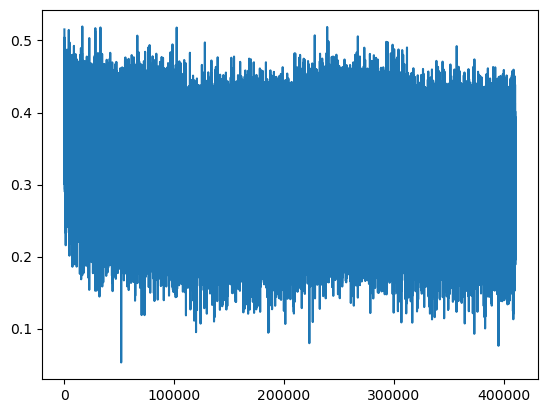

In [32]:
max_steps = 200_000
batch_size = 32
epsilon = 0.00001

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # wasteful bias with no gradient whatsoever
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani / (bnstdi + epsilon)) + bnbias # batch normalization

    # solution 2:
    with torch.no_grad(): # running mean update
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # momentum = 0.001
        bnstd_running  = 0.999 * bnstd_running  + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(i, loss.item())
    lossi.append(loss.log10().item())
    
plt.plot(lossi)

In [19]:
# problem: the batch normalization required a batch of examples so it was impossible to process single one
# solution 1: compute bnmean and bnstd on the entire dataset
# solution 2: introduce bnmean_running and bnstd_running in training

# solution 1:
with torch.no_grad():
    # on all training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [31]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - bnmean / bnstd) + bnbias
    hpreact = bngain * (hpreact - bnmean_running / (bnstd_running + epsilon)) + bnbias
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train'), split_loss('val')

train 2.214567184448242
val 2.2895219326019287


(None, None)

### ResNet - Residual Neural Network 
- for image classification
- [conv + batchnorm + relu] * 3 stacked layers
- https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [10]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

xivi.
aya.
teem.
brigansh.
abel.
deme.
myrriganni.
maxxancone.
tahaia.
tubdiry.
cauzuelen.
azerick.
ever.
grann.
atvi.
julie.
kari.
aubrins.
colaylona.
jaydtoder.
